# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [4]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [5]:
# I focus on random.uniform distribution of volatility

# Hedging with constant volatility

In [6]:
%run functions.py

In [7]:
import types

# List all functions in functions_black_scholes.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])

['__nonzero__', 'brentq', 'quad', 'bs_call', 'bs_put', 'bs_call_delta', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta', 'bs_call_rho', 'bs_put_rho', 'gbm_path_sim', 'bs_MC_call_delta', 'bs_MC_call_delta_array', 'bs_MC_call', 'bs_MC_put_delta', 'bs_MC_put_delta_array', 'bs_MC_put', 'bs_MC_call_fast', 'implied_volatility_call', 'implied_volatility_put', 'heston_path_sim', 'heston_call_MC', 'heston_put_MC', 'heston_call', 'heston_put']


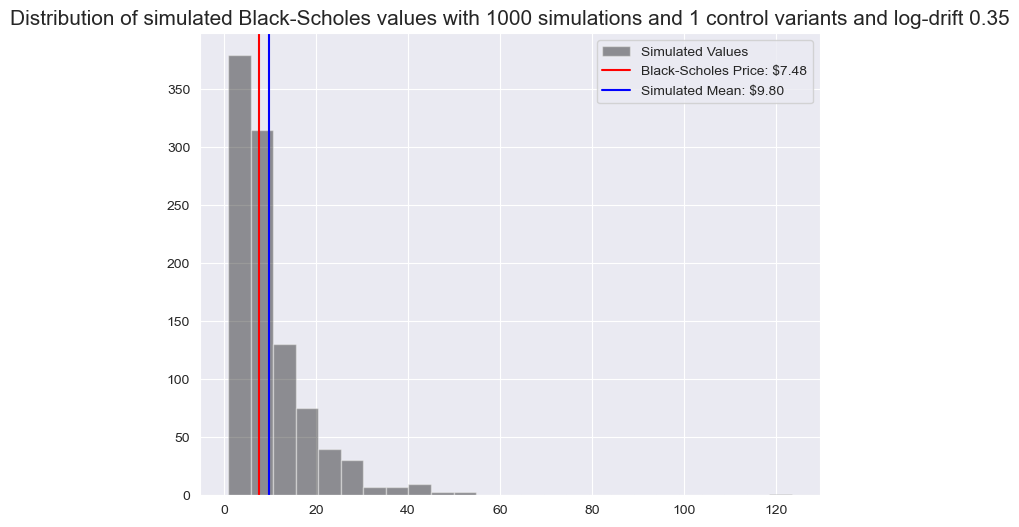

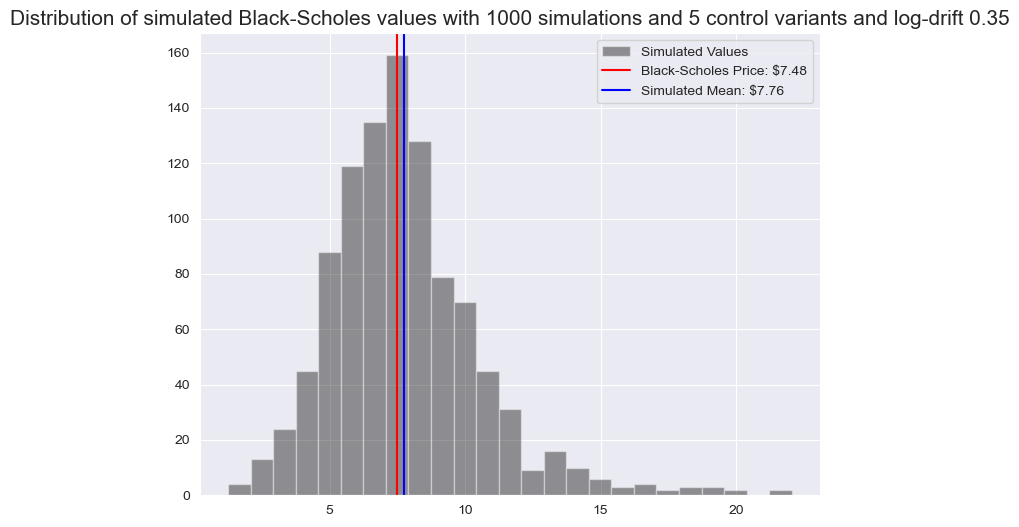

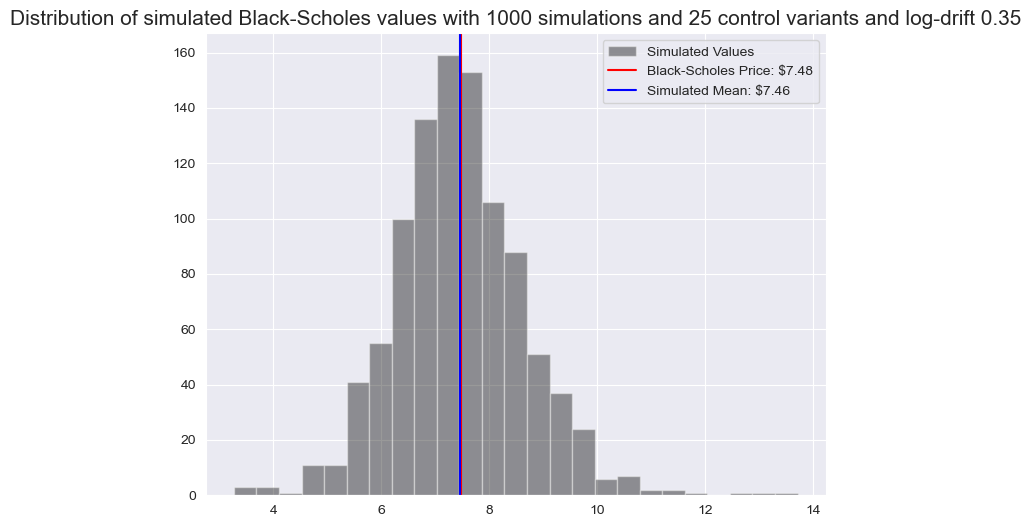

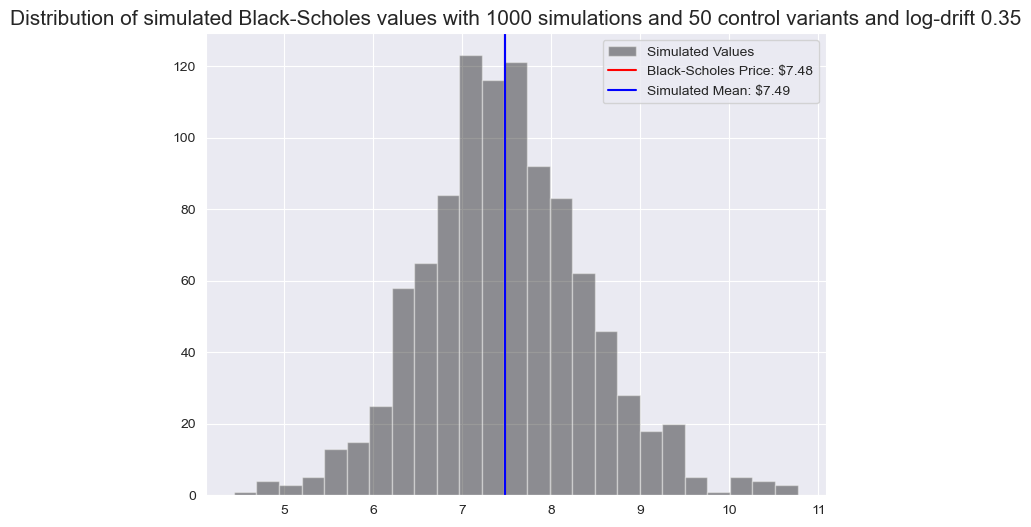

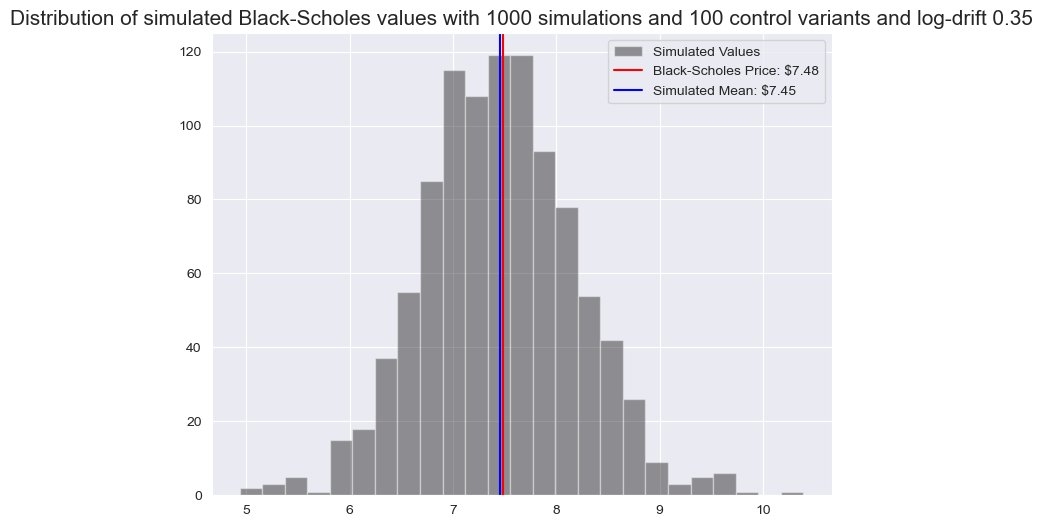

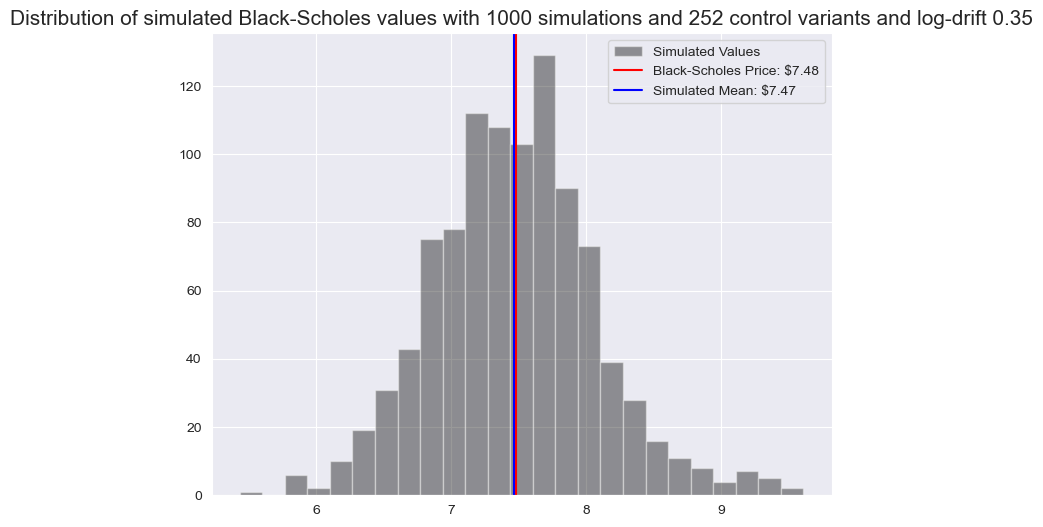

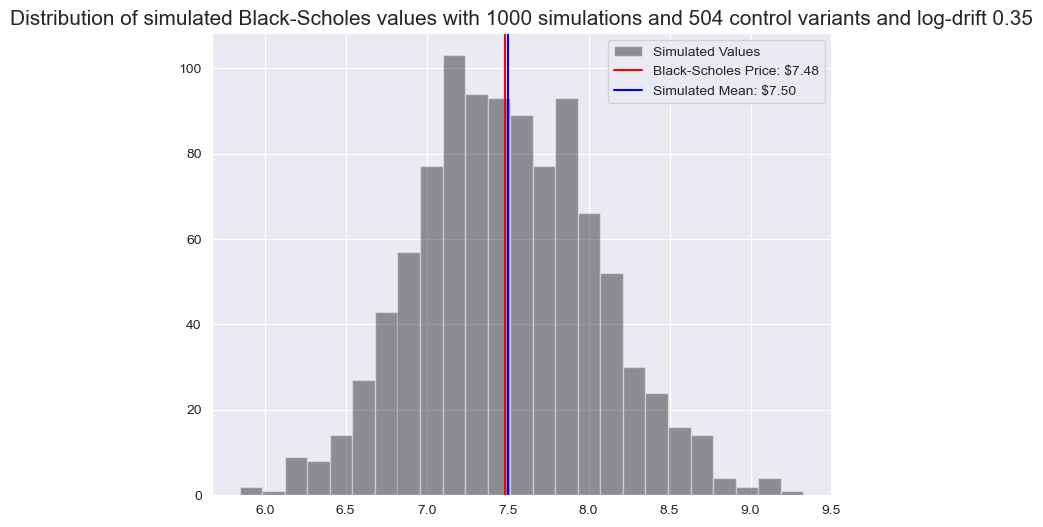

In [6]:
#Black-Scholes Price of Call Option
S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04
mu = .35 #Drift of stock movement
delta_sims = 500

n_sims = 1000

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call(S0, K, sigma, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




# Hedging with different volatility per simulation path (i.e., sigma is constant along each path)

In [ ]:
def bs_MC_call_var_sigma1(S0, K, r, t, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    noise = np.random.normal(0,1,(n_sims,n_hedges))
    sigmas = np.zeros((n_sims,n_hedges))
    sigmas[:,0] = np.random.uniform(0.1,0.5,n_sims) 
    for i in range(1,n_hedges):  #Randomly generated volatility for each simulation, but not each hedge
        sigmas[:,i] = sigmas[:,0] # Each hedge has the same volatility as the first hedge


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu + r - .5*sigmas**2)*dt + sigmas*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)


    sigma = np.mean(sigmas[:,0])  # We use the average sigma from all paths to be used in determining the deltas.

    delta_start = bs_MC_call_delta(S0,K,sigma,t,r,delta_sims) 

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)*delta_start

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_MC_call_delta_array(stock_start, K, sigma, tte, r,delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged



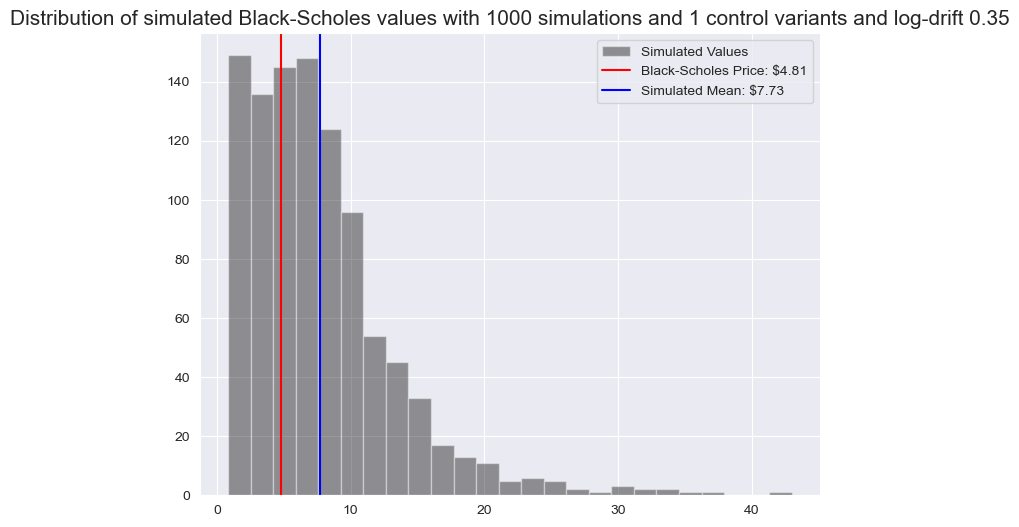

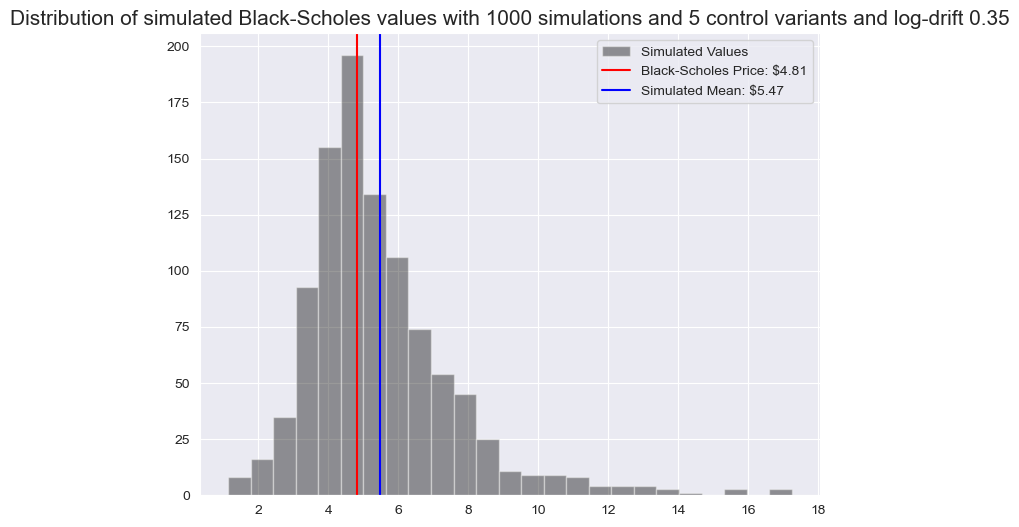

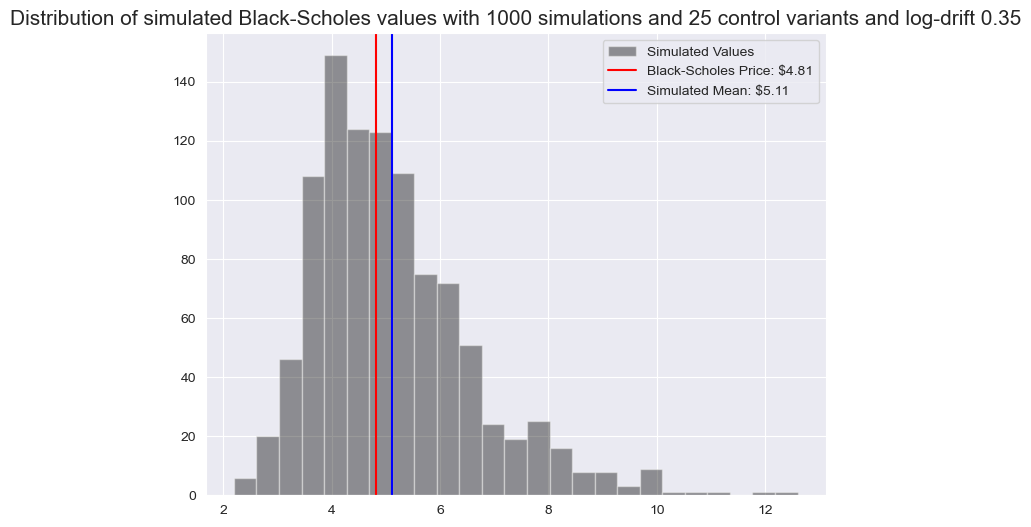

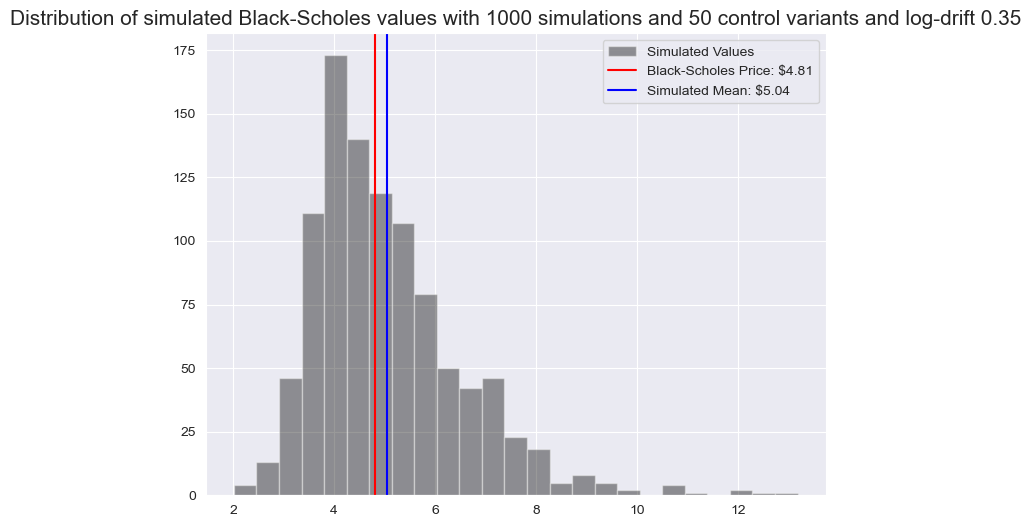

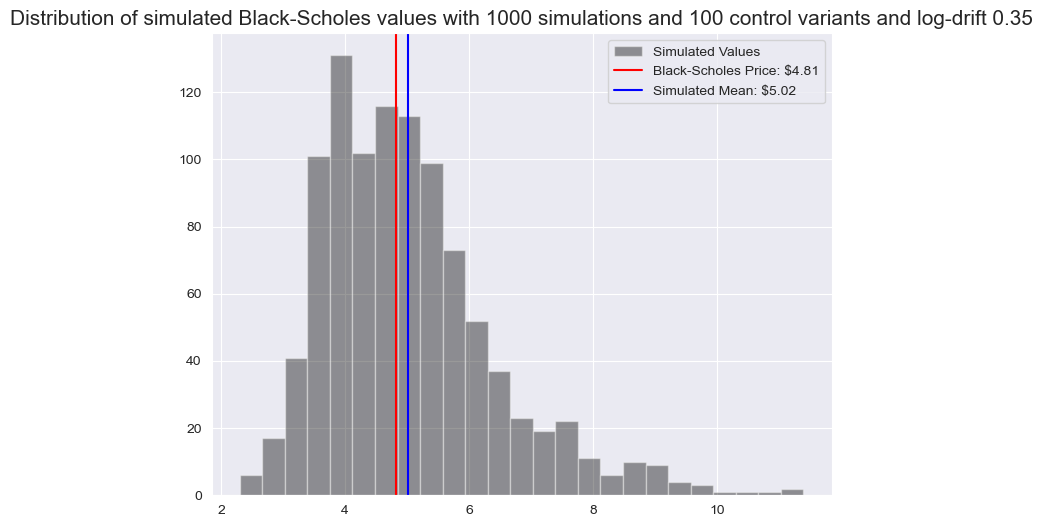

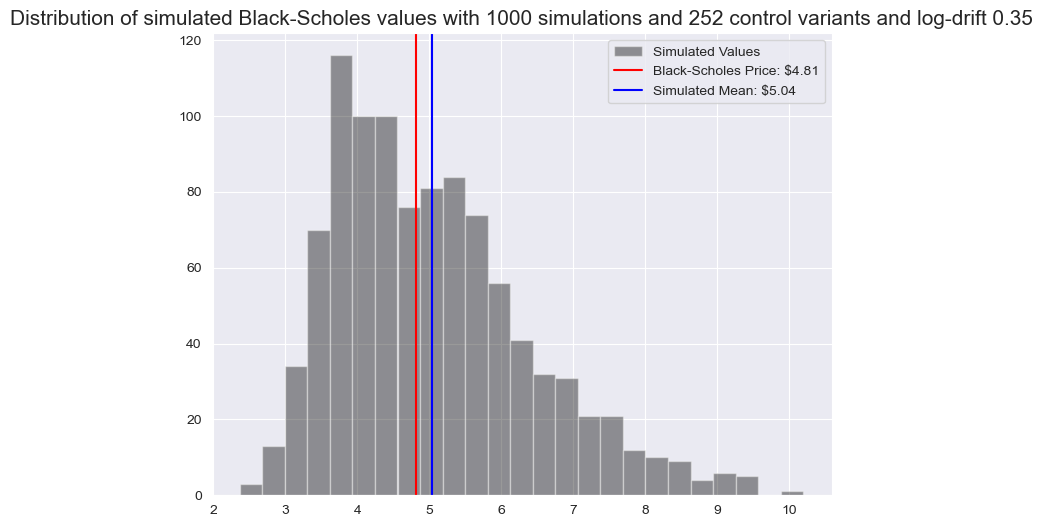

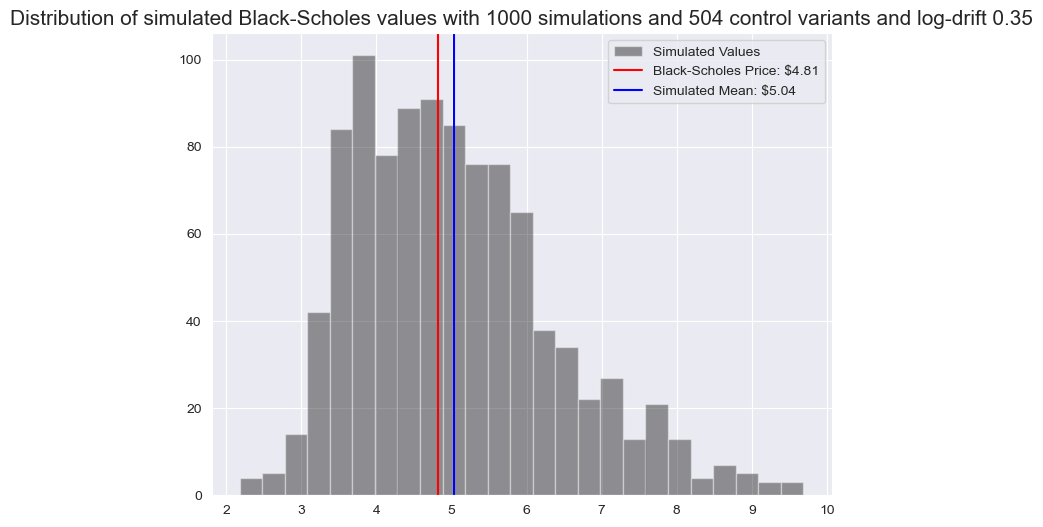

In [11]:
#Black-Scholes Price of Call Option
S0 = 35
K = 35
sigma = (0.5+0.1)/2 #Average of the random volatility
t = 1
r = 0.04
mu = .35 #Drift of stock movement
delta_sims = 500

n_sims = 1000

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call_var_sigma1(S0, K, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




In [ ]:
# Hedging does seem to improve the results, but not as much as with constant volatility.
# One difference is the use of average volatility for the bs_call estimate.
# Another difference may be the use of an average sigma in delta calculations that is different from the sigma used in bs_call.

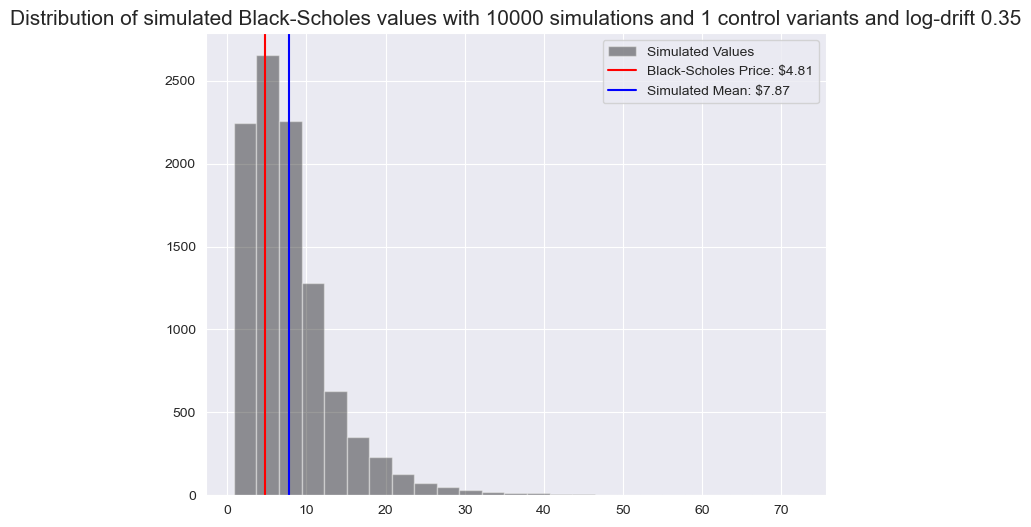

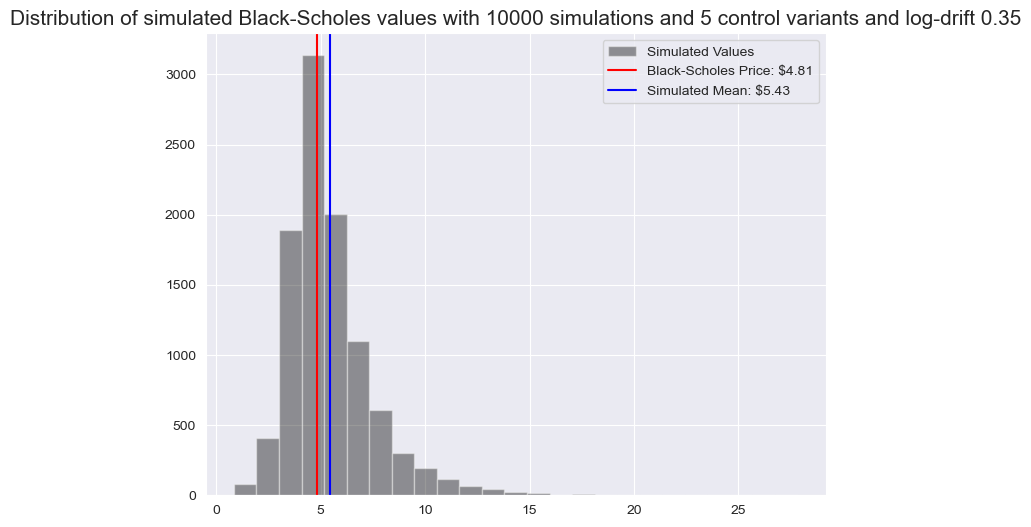

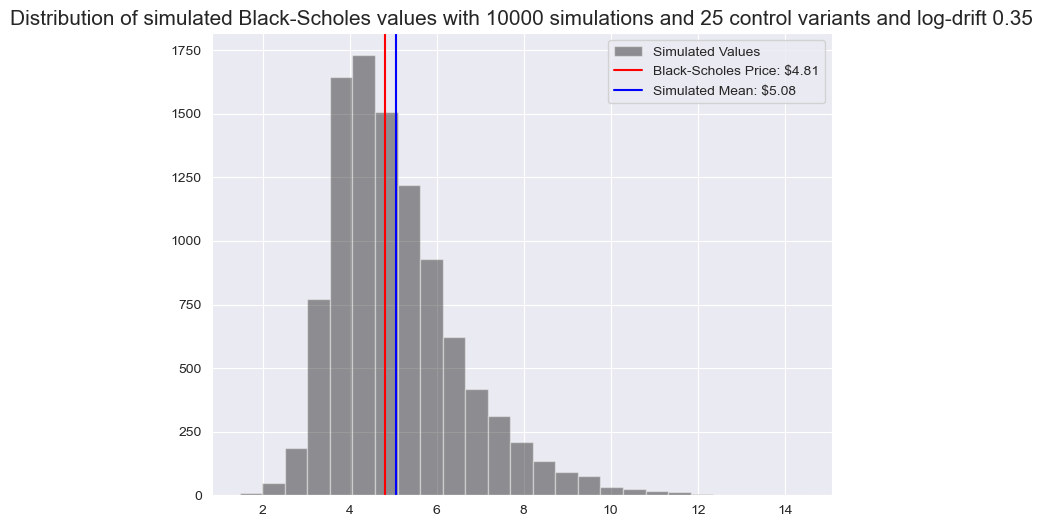

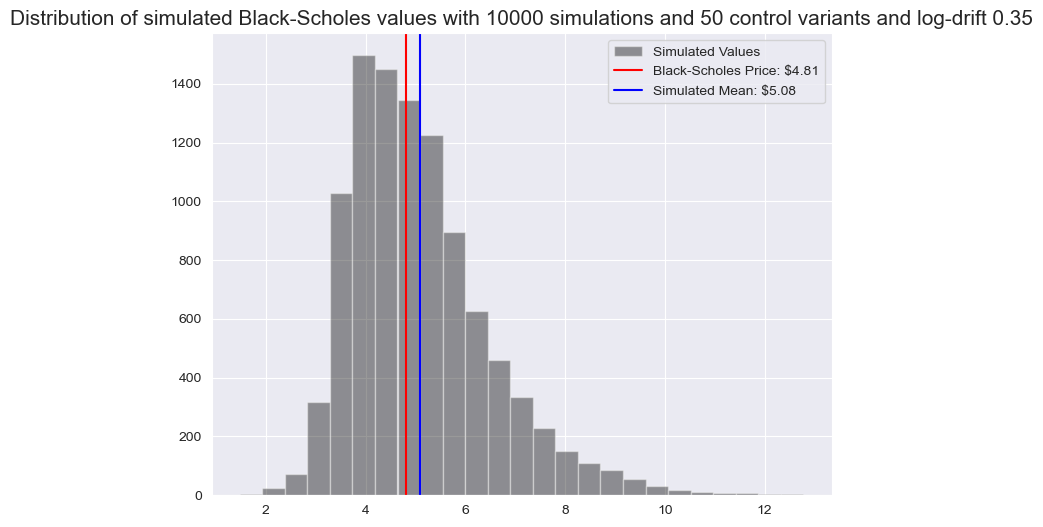

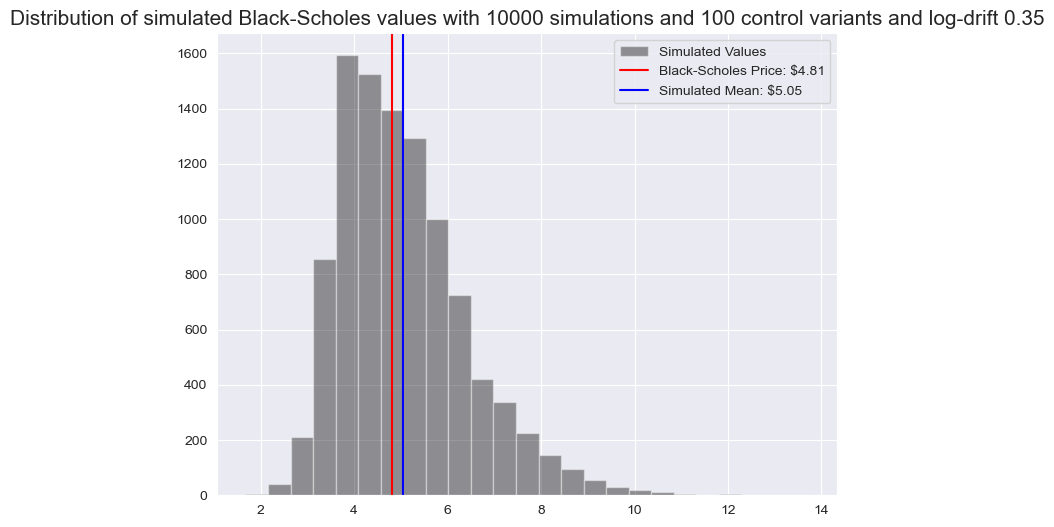

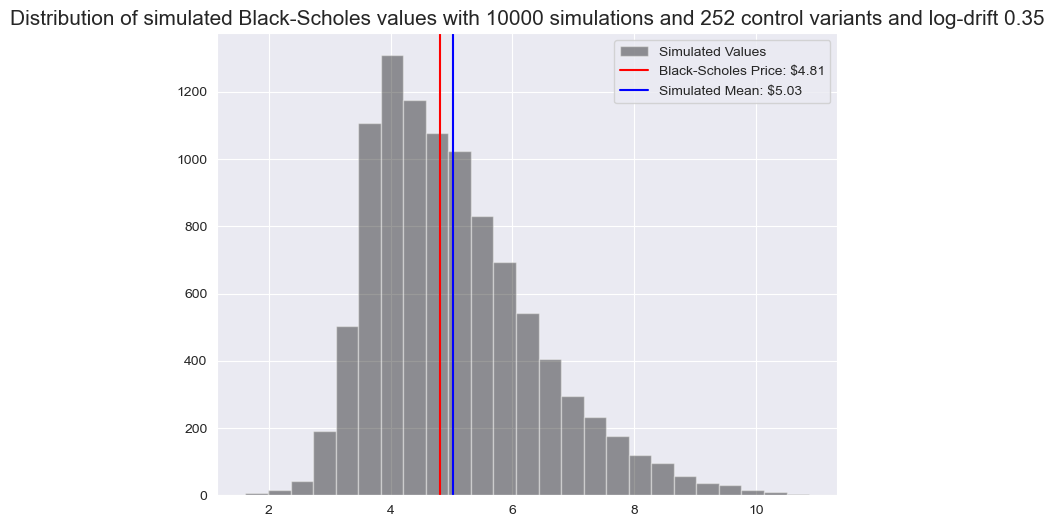

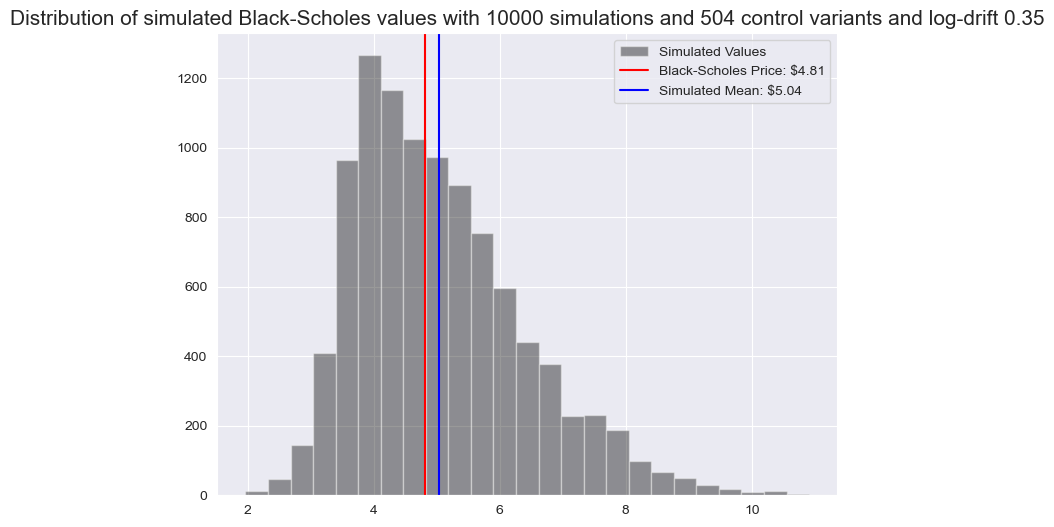

In [ ]:
# Maybe increasing the number of simulations will help with neutralize the second point?


S0 = 35
K = 35
sigma = (0.5+0.1)/2 #Average of the random volatility
t = 1
r = 0.04
mu = .35 #Drift of stock movement
delta_sims = 500

n_sims = 10000  # Increased number of simulations

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call_var_sigma1(S0, K, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




In [ ]:
# Increasing the number of simulations does seem to help with the second issue, but the results are still not as good as with constant volatility.
# I believe this just CLT at work, and the results will improve with more simulations.

# Maybe the drift is actually significant when the volatility is not constant?
# Let's try a few different values of mu to see how it affects the results.

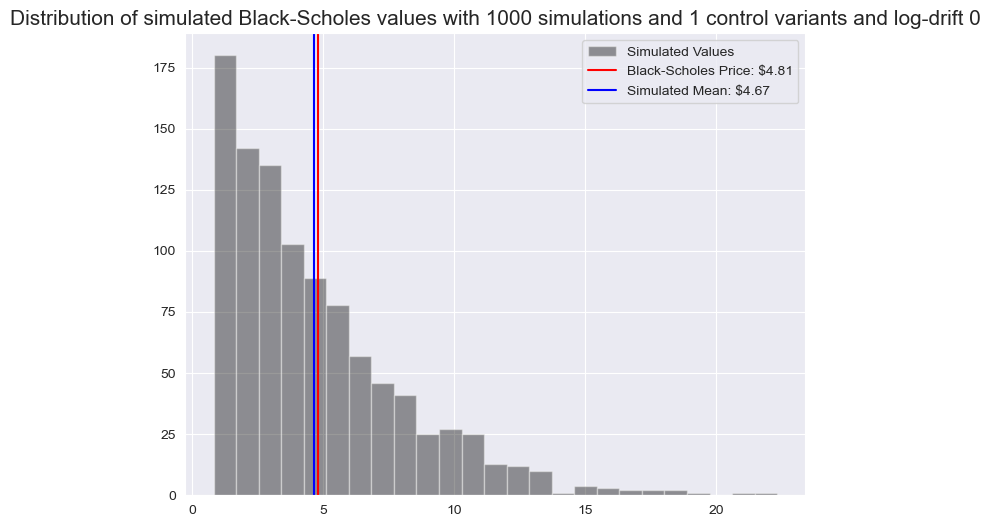

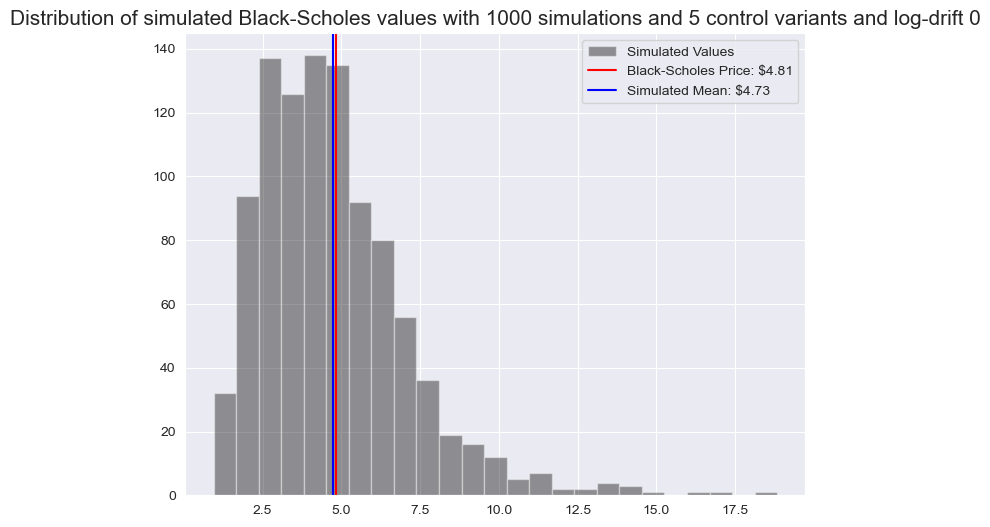

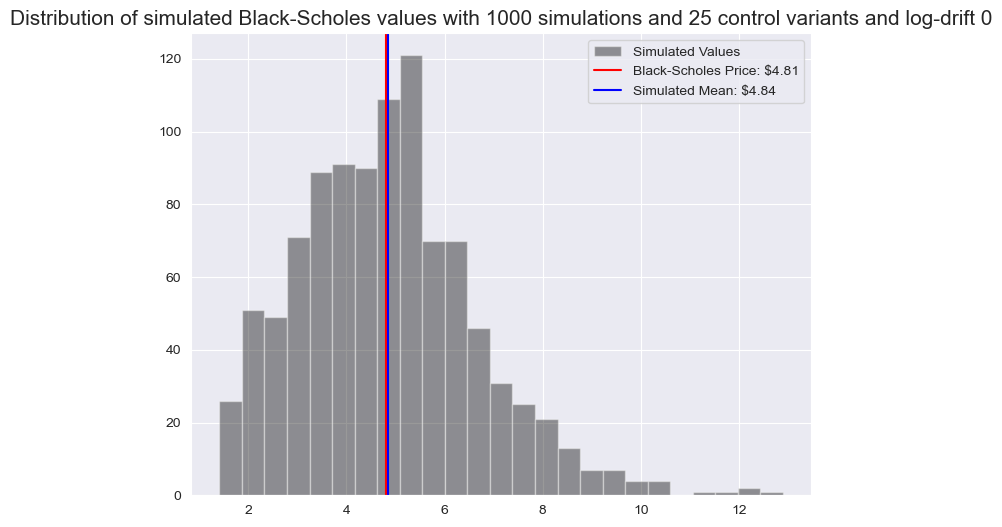

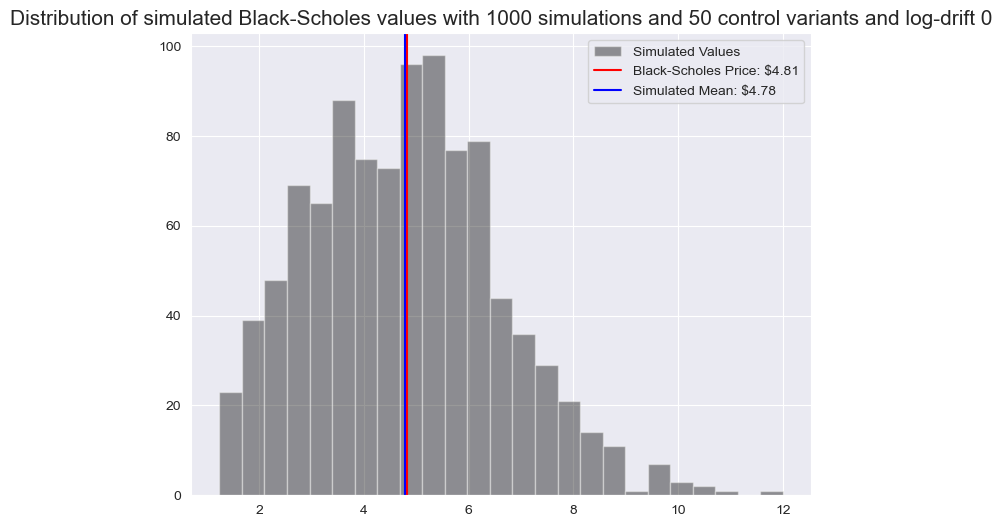

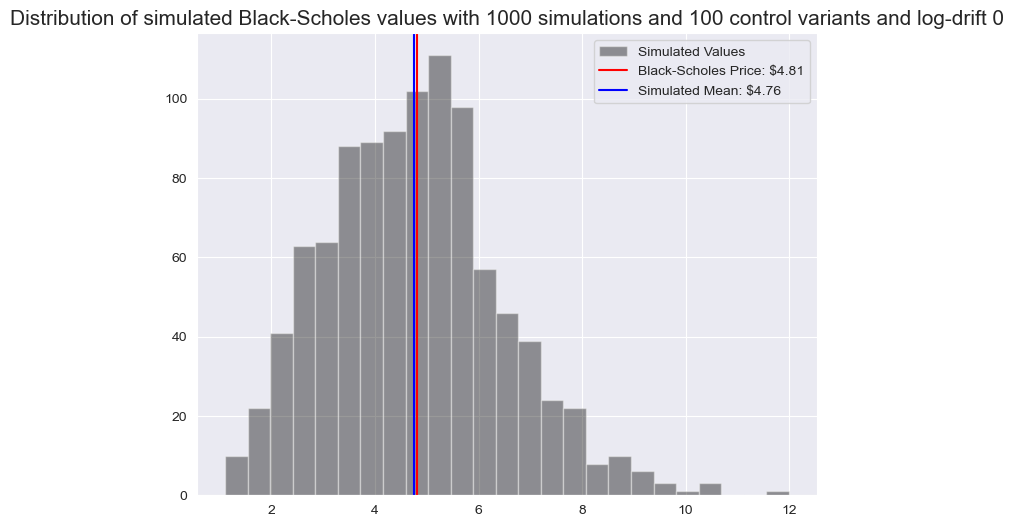

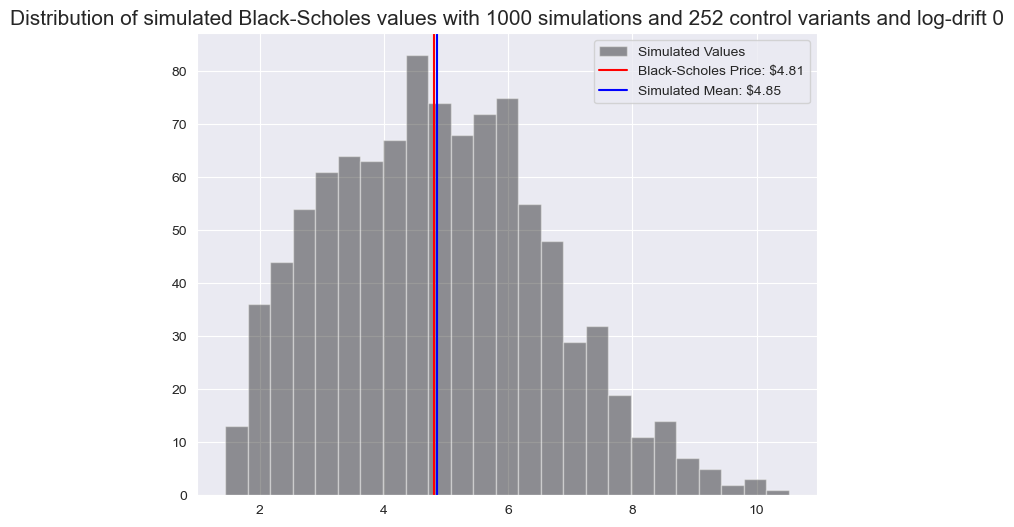

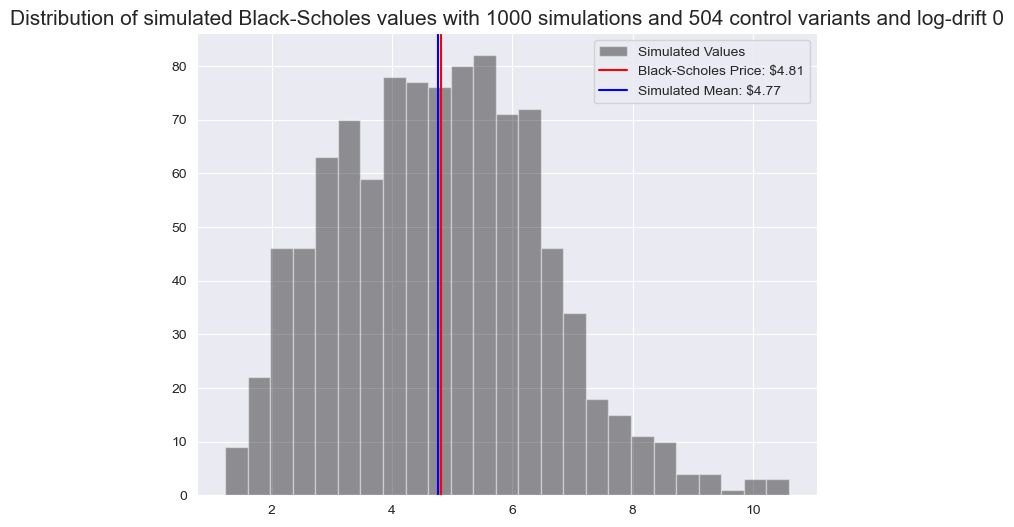

In [16]:
# Maybe increasing the number of simulations will help with the second issue?


S0 = 35
K = 35
sigma = (0.5+0.1)/2 #Average of the random volatility
t = 1
r = 0.04
mu = 0 #Drift of stock movement
delta_sims = 500

n_sims = 1000  # Increased number of simulations

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call_var_sigma1(S0, K, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




In [ ]:
# It's clear that the drift is significant when the volatility is not constant.
# This implies that hedging doesn't neutralize the drift term as it was the case in constant volatility scenarios.

In [ ]:
# Another key point is that the call price we get from our simulations tend to be larger than the bs_call price, which is more in line with what happens in real life.

# Hedging with different volatility per step

In [8]:
def bs_MC_call_var_sigma2(S0, K, r, t, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    noise = np.random.normal(0,1,(n_sims,n_hedges))
    sigmas = np.random.uniform(0.1,0.5,(n_sims,n_hedges)) #Randomly generated volatility for each step


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigmas**2)*dt + sigmas*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)


    sigma_start = np.mean(sigmas[:,0])  # We use the average sigma from all hedges to be used in determining the deltas.

    delta_start = bs_MC_call_delta(S0,K,sigma_start,t,r,delta_sims) # Takes the array of sigmas and returns the delta for the first hedge

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)*delta_start

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        sigma = np.mean(sigmas[:,i]) # We use the average sigma of that simulation path to be used in determining the deltas.
        deltas = bs_MC_call_delta_array(stock_start, K, sigma, tte, r,delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged



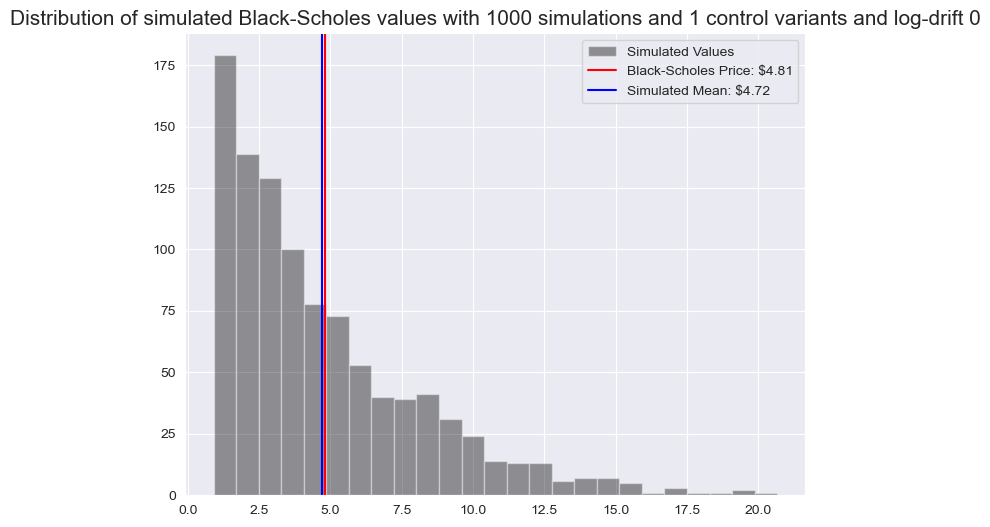

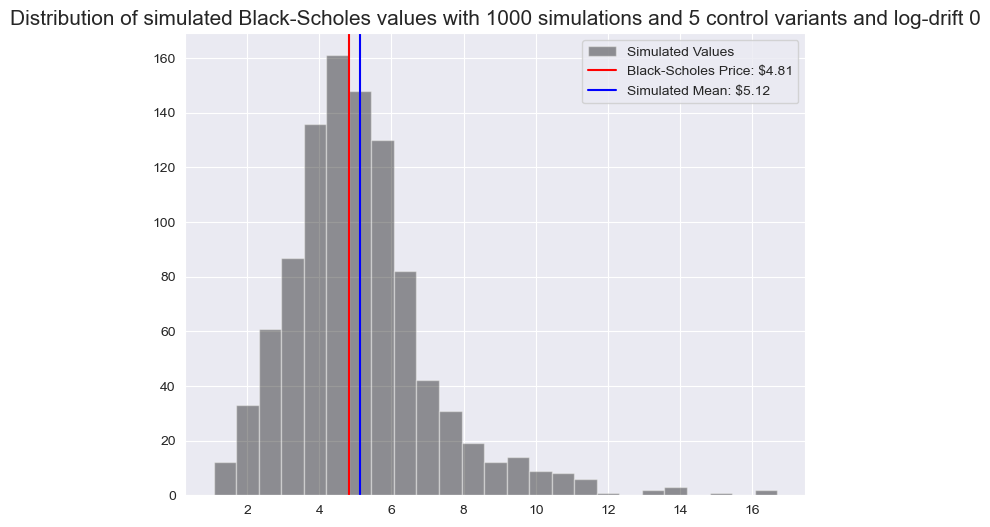

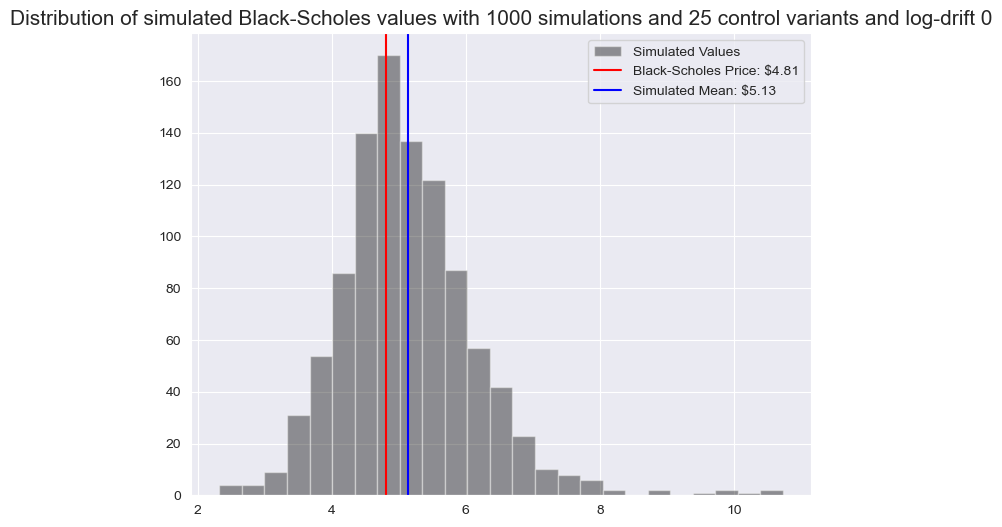

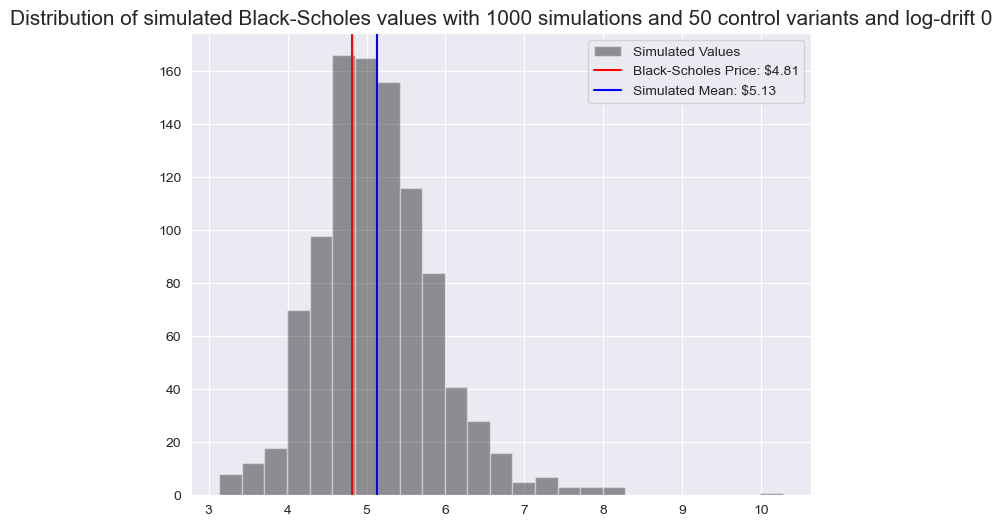

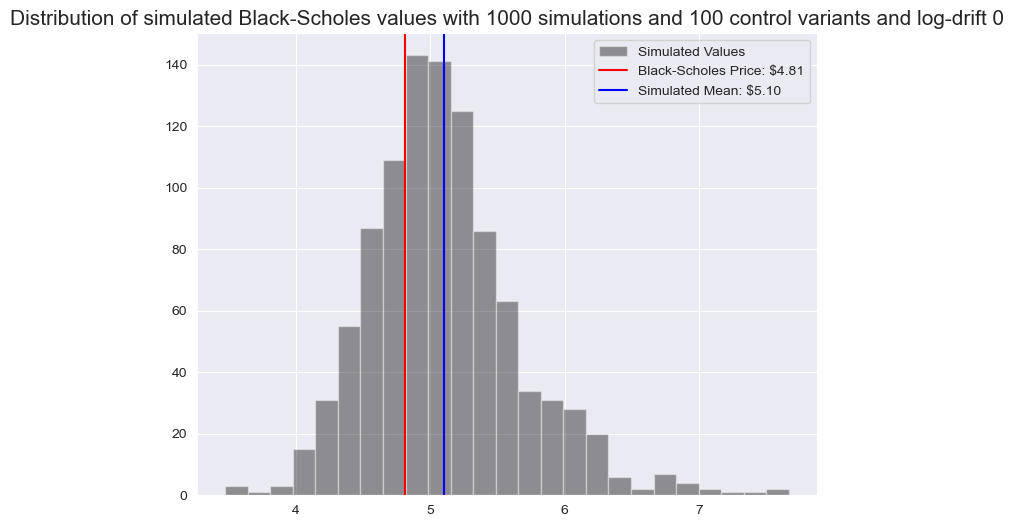

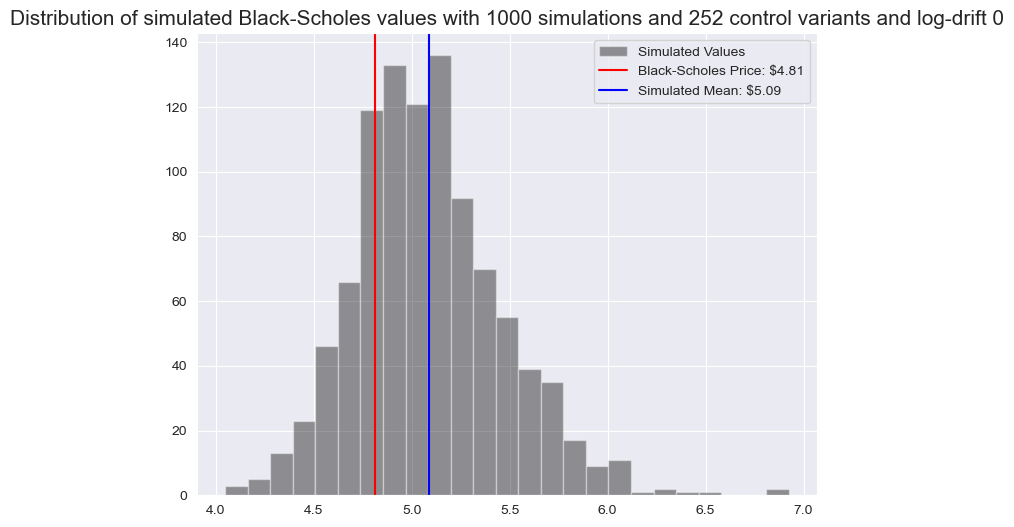

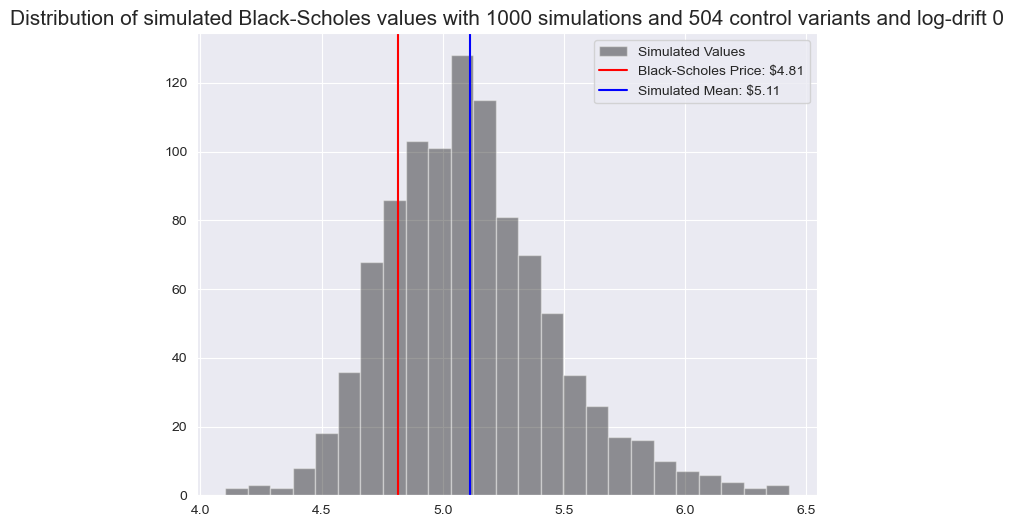

In [21]:
S0 = 35
K = 35
sigma = (0.5+0.1)/2 #Average of the random volatility we chose in our functions
t = 1
r = 0.04
mu = 0 #Drift of stock movement
delta_sims = 500

n_sims = 1000  # Increased number of simulations

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call_var_sigma2(S0, K, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




In [ ]:
# Hedging becomes more ineffective as the volatility becomes more variable within the path.
# Or one can say that the bs_call is not a good estimate of the value of the call option when the volatility is totally random as within the last case.
# This seems more predictive of the actual value of the call option (being larger than the Black-Scholes price).

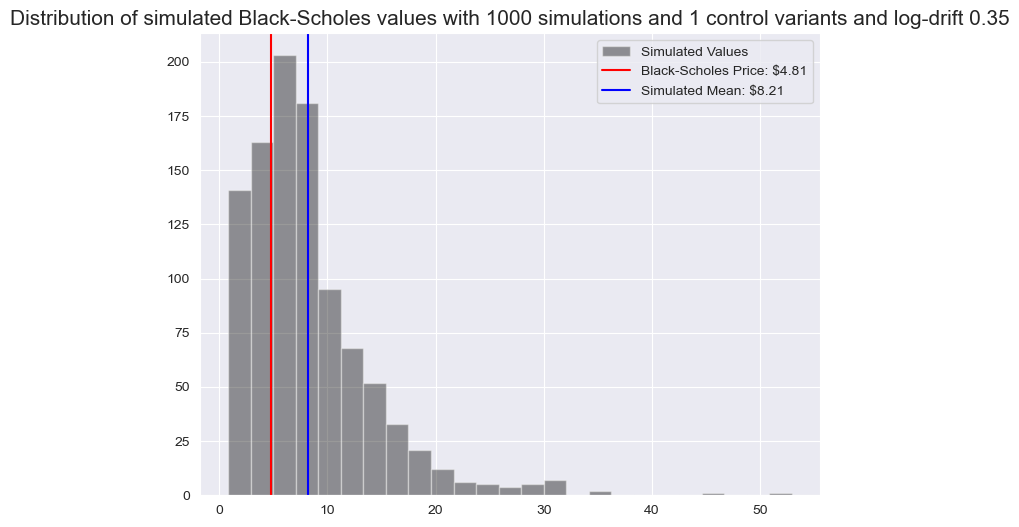

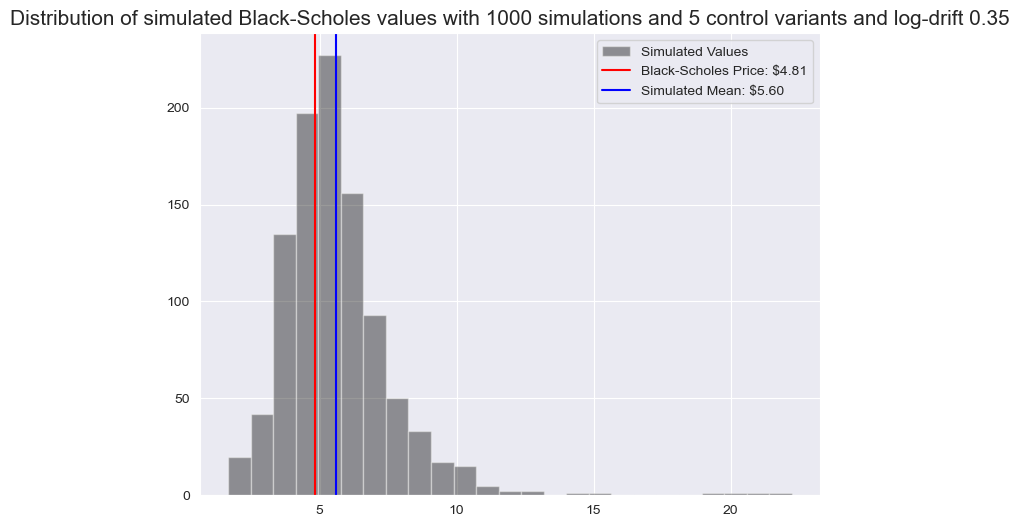

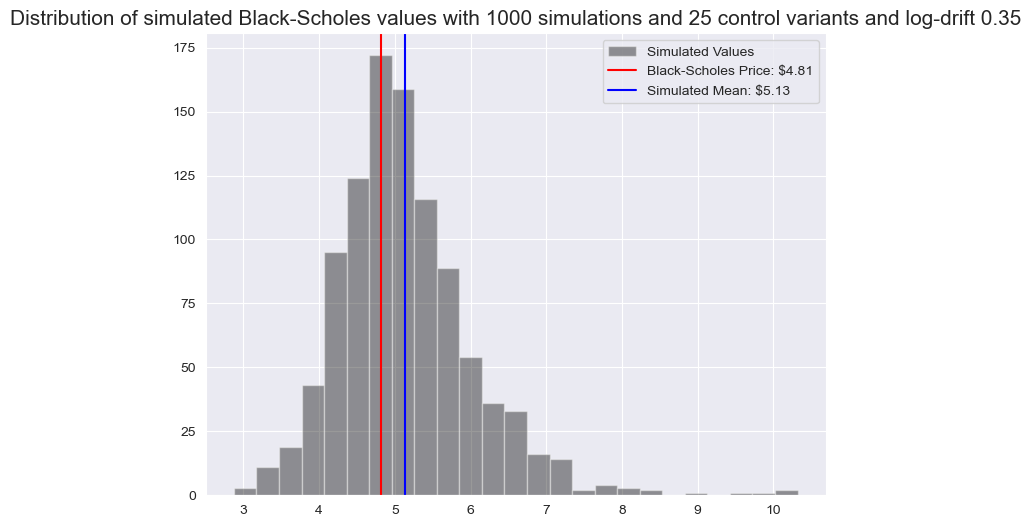

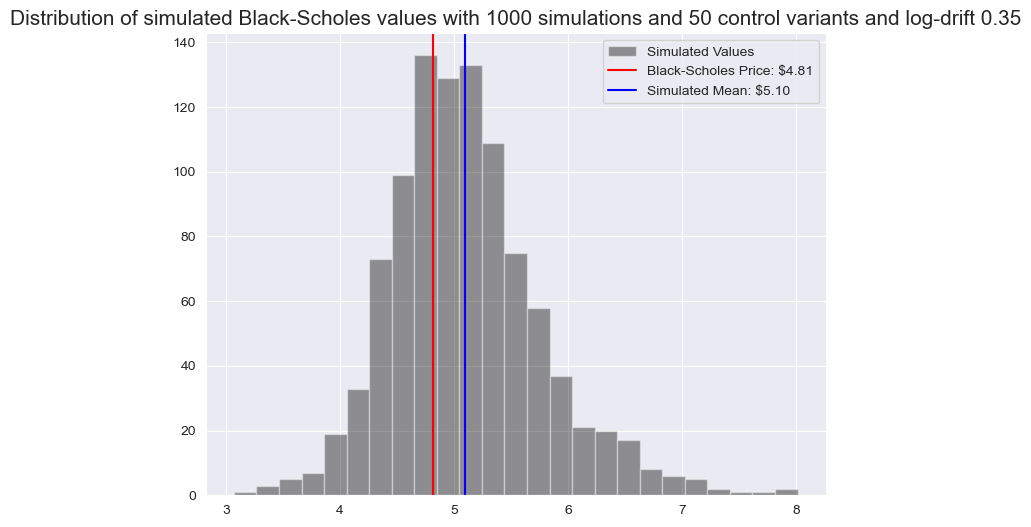

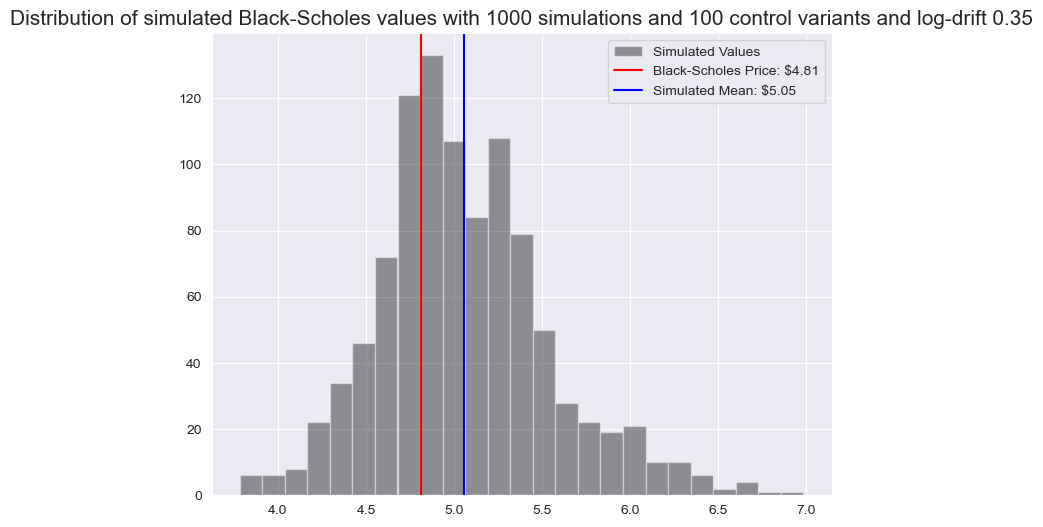

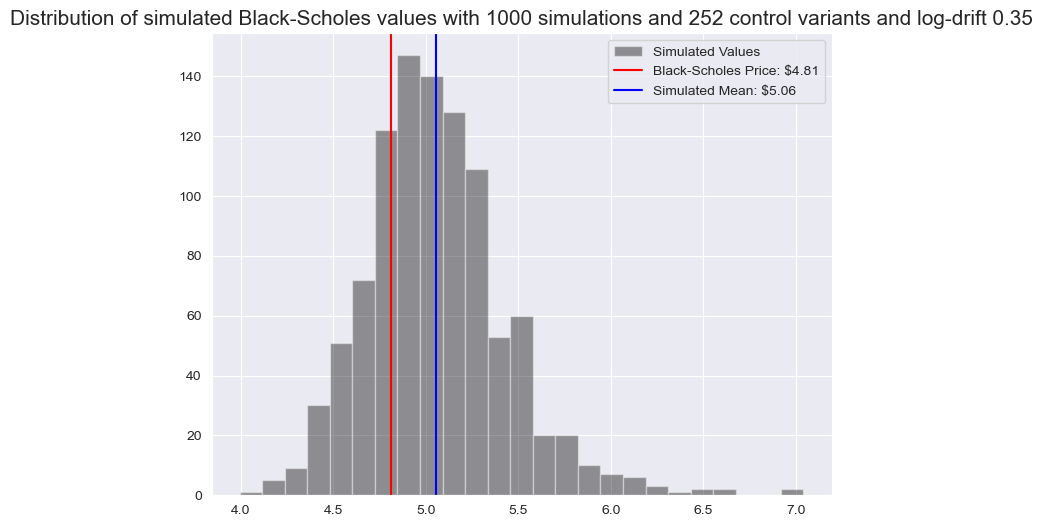

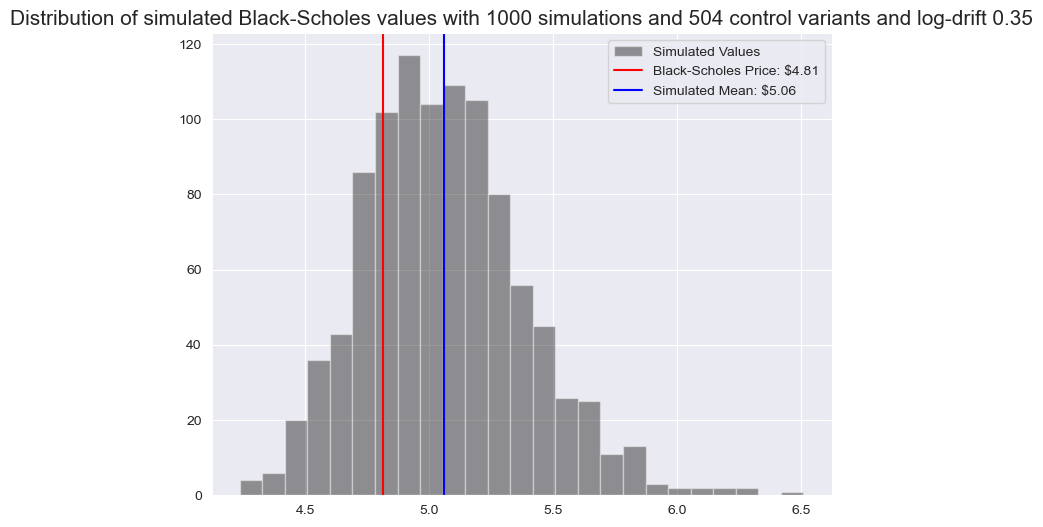

In [9]:
# Keeping the drift term.
S0 = 35
K = 35
sigma = (0.5+0.1)/2 #Average of the random volatility we chose in our functions
t = 1
r = 0.04
mu = 0.35 #Drift of stock movement
delta_sims = 500

n_sims = 1000  # Increased number of simulations

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call_var_sigma2(S0, K, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()


